<a href="https://colab.research.google.com/github/sexymonster/Dacon/blob/main/tour22AI/2022%EA%B4%80%EA%B4%91%EB%8D%B0%EC%9D%B4%ED%84%B0AI%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 인트로

## 1-1. 문제 유형 및 데이터 정리

<링크> https://dacon.io/competitions/official/235978/overview/description \
train.csv\
id : 샘플 별 고유 id\
img_path : 샘플에 해당되는 이미지 경로\
overview : 샘플에 해당되는 부가 설명 (text)\
cat1 : 샘플의 '대' 분류 정보 (Meta 정보) \
cat2 : 샘플의 '중' 분류 정보 (Meta 정보)\
cat3 : 샘플의 '소' 분류 정보 (모델이 예측해야 할 Label)\


test.csv\
id : 샘플 별 고유 id\
img_path : 샘플에 해당되는 이미지 경로\
overview : 샘플에 해당되는 부가 설명 (text)\


sample_submission.csv\
id : 샘플 별 고유 id\
cat3 : 샘플의 '소' 분류 정보 (모델이 예측해야 할 Label)\
예측 Label에 빈 값이 있는 경우 제출이 불가능합니다.


## 1-2. 패키지 로드

In [1]:
from google.colab import drive

import random
import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings(action='ignore')

## 1-3. 데이터 로드

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv("/content/drive/MyDrive/tour2022AI/train.csv")
test = pd.read_csv("/content/drive/MyDrive/tour2022AI/test.csv")
sub = pd.read_csv("/content/drive/MyDrive/tour2022AI/sample_submission.csv")

# 2. 전처리

## 2-1. 하이퍼 파라미터 세팅

In [8]:
CFG = {
    'IMG_SIZE':128,
    'EPOCHS':5,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':64,
    'SEED':41
}

## 2-2. 랜덤시드 고정

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [10]:
train_df, val_df, _, _ = train_test_split(train, train['cat3'], test_size=0.2, random_state=CFG['SEED'])

## 2-3. 라벨 인코딩

In [11]:
le = preprocessing.LabelEncoder()
le.fit(train_df['cat3'].values)

LabelEncoder()

In [12]:
train_df['cat3'] = le.transform(train_df['cat3'].values)
val_df['cat3'] = le.transform(val_df['cat3'].values)

In [14]:
train_df

,id,img_path,overview,cat1,cat2,cat3
1786,TRAIN_01786,./image/train/TRAIN_01786.jpg,함평양서파충류생태공원은 전남 함평군 신광면에 자리 잡고 있다. 공원 내에는 양서류를...,인문(문화/예술/역사),문화시설,44
16670,TRAIN_16670,./image/train/TRAIN_16670.jpg,국제수변레포츠 단지 내 위치한 충주 탄금호 캠핑 리조트는 다양한 문화체험이 가능한 ...,레포츠,육상 레포츠,73
3377,TRAIN_03377,./image/train/TRAIN_03377.jpg,경남 함양군 서하면에 위치한 함양 라온캠핑장은 마운틴뷰의 조용하고 깨끗한 신설 캠핑...,레포츠,육상 레포츠,73
12814,TRAIN_12814,./image/train/TRAIN_12814.jpg,캠프바베큐는 충남 천안시 동남구에 자리 잡고 있다. 천안시청을 기점으로 약 8㎞가량...,레포츠,육상 레포츠,73
2607,TRAIN_02607,./image/train/TRAIN_02607.jpg,"원수산습지생태원은 세종시 연기면 세종리에 있다. 생태원 내에는 보존습지, 수생식물습...",자연,자연관광지,93
...,...,...,...,...,...,...
6819,TRAIN_06819,./image/train/TRAIN_06819.jpg,"밤바다의 멋진 야경을 보며 걷는 물 위의 데크 산책로, 바다 위에 조성된 742m의...",인문(문화/예술/역사),건축/조형물,21
15829,TRAIN_15829,./image/train/TRAIN_15829.jpg,남해비치텔은 한려해상 국립공원의 중심지역인 남해군 설천면 노량리에 위치해 있다. 이...,숙박,숙박시설,31
8513,TRAIN_08513,./image/train/TRAIN_08513.jpg,장경리해변은 자갈모래로 형성된 해변을 가지고 있으며 백사장의 길이는 1.5km 정도...,자연,자연관광지,121
931,TRAIN_00931,./image/train/TRAIN_00931.jpg,서울 종로에 자리한 낙원떡집은 ‘서울미래유산’으로도 선정될 만큼 오랜 역사와 전통을...,음식,음식점,118


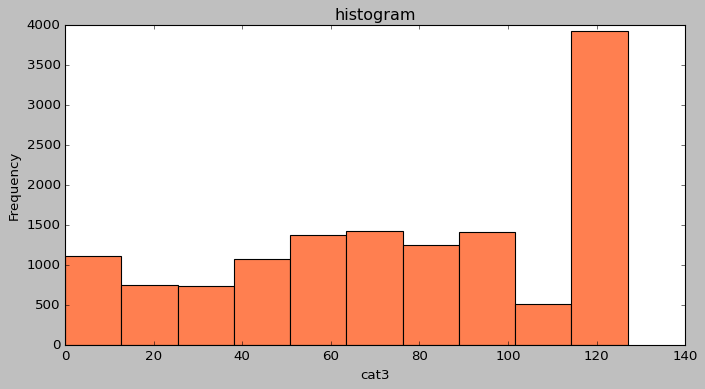

In [15]:
import matplotlib.pyplot as plt
plt.style.use("classic")
train_df['cat3'].plot(kind="hist", bins=10, color="coral",figsize=(10,5))
plt.title("histogram")
plt.xlabel("cat3")
plt.show()

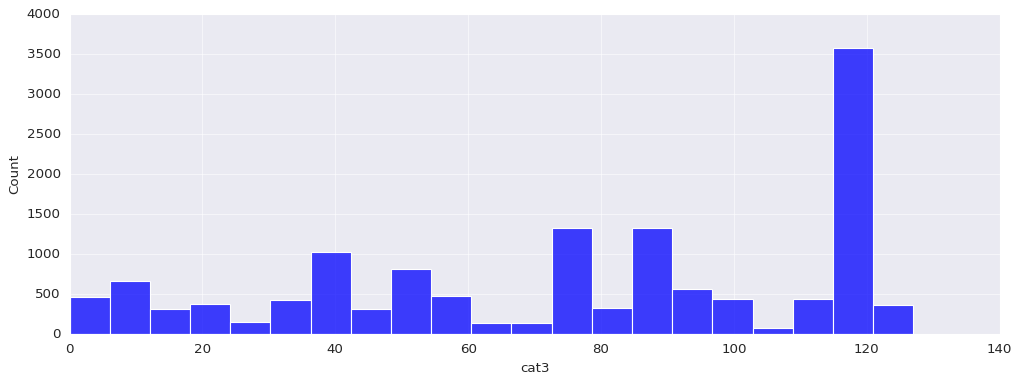

In [16]:
import seaborn as sns
sns.set_style("darkgrid")
fig = plt.figure(figsize=(15,5))
sns.histplot(x="cat3",data=train_df)
plt.show()

## 2-4. Vectorizer

In [17]:
vectorizer = CountVectorizer(max_features=4096)

train_vectors = vectorizer.fit_transform(train_df['overview'])
train_vectors = train_vectors.todense()

val_vectors = vectorizer.transform(val_df['overview'])
val_vectors = val_vectors.todense()

In [18]:
train_vectors.shape

(13588, 4096)

In [19]:
val_vectors.shape

(3398, 4096)

## 2-5. CustomDataset

In [20]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, text_vectors, label_list, transforms, infer=False):
        self.img_path_list = img_path_list
        self.text_vectors = text_vectors
        self.label_list = label_list
        self.transforms = transforms
        self.infer = infer
        
    def __getitem__(self, index):
        # NLP
        text_vector = self.text_vectors[index]
        
        # Image
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        # Label
        if self.infer:
            return image, torch.Tensor(text_vector).view(-1)
        else:
            label = self.label_list[index]
            return image, torch.Tensor(text_vector).view(-1), label
        
    def __len__(self):
        return len(self.img_path_list)

In [21]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [22]:
train_dataset = CustomDataset(train_df['img_path'].values, train_vectors, train_df['cat3'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=6)

val_dataset = CustomDataset(val_df['img_path'].values, val_vectors, val_df['cat3'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

## 2-6.Model Define

In [23]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(CustomModel, self).__init__()
        # Image
        self.cnn_extract = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Text
        self.nlp_extract = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
        )
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(4160, num_classes)
        )
            

    def forward(self, img, text):
        img_feature = self.cnn_extract(img)
        img_feature = torch.flatten(img_feature, start_dim=1)
        text_feature = self.nlp_extract(text)
        feature = torch.cat([img_feature, text_feature], axis=1)
        output = self.classifier(feature)
        return output

# 3. 학습 & 예측

## 3-1. Train

In [24]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    best_score = 0
    best_model = None
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        for img, text, label in tqdm(iter(train_loader)):
            img = img.float().to(device)
            text = text.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()

            model_pred = model(img, text)
            
            loss = criterion(model_pred, label)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        tr_loss = np.mean(train_loss)
            
        val_loss, val_score = validation(model, criterion, val_loader, device)
            
        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step()
            
        if best_score < val_score:
            best_score = val_score
            best_model = model
    
    return best_model

In [25]:
def score_function(real, pred):
    return f1_score(real, pred, average="weighted")

def validation(model, criterion, val_loader, device):
    model.eval()
    
    model_preds = []
    true_labels = []
    
    val_loss = []
    
    with torch.no_grad():
        for img, text, label in tqdm(iter(val_loader)):
            img = img.float().to(device)
            text = text.to(device)
            label = label.to(device)
            
            model_pred = model(img, text)
            
            loss = criterion(model_pred, label)
            
            val_loss.append(loss.item())
            
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()
        
    test_weighted_f1 = score_function(true_labels, model_preds)
    return np.mean(val_loss), test_weighted_f1

## 3-2. Run

In [26]:
model = CustomModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

NameError: ignored

## 3-3. Inference

In [29]:
test_vectors = vectorizer.transform(test['overview'])
test_vectors = test_vectors.todense()

test_dataset = CustomDataset(test['img_path'].values, test_vectors, None, test_transform, True)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

In [30]:
def inference(model, test_loader, deivce):
    model.to(device)
    model.eval()
    
    model_preds = []
    
    with torch.no_grad():
        for img, text in tqdm(iter(test_loader)):
            img = img.float().to(device)
            text = text.to(device)
            
            model_pred = model(img, text)
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
    
    return model_preds

In [31]:
preds = inference(infer_model, test_loader, device)

NameError: ignored

## 4. 성능 지표 확인

# 5. 저장

## 5-1. Submission

In [32]:
sub['cat3'] = le.inverse_transform(preds)

NameError: ignored

In [ ]:
sub.to_csv('./submit.csv', index=False)

In [6]:
train.iloc[20:30,:]

,id,img_path,overview,cat1,cat2,cat3
20,TRAIN_00020,./image/train/TRAIN_00020.jpg,절벽과 강을 사이에 두고 바위를 깎아 세운 듯하다. 거대한 촛대를 세워 놓은 것 같...,인문(문화/예술/역사),휴양관광지,관광단지
21,TRAIN_00021,./image/train/TRAIN_00021.jpg,전남 여수시에 위치한 트윈스모텔은 창문마다 작은 테라스가 달려있어 귀여운 느낌의 건...,숙박,숙박시설,모텔
22,TRAIN_00022,./image/train/TRAIN_00022.jpg,주양두리돈까스는 암사동 선사고등학교 부근에 있다. 이곳은 26년 전통의 음식점으로 ...,음식,음식점,일식
23,TRAIN_00023,./image/train/TRAIN_00023.jpg,"지산리조트 인근에 위치한 와우스키 렌탈샵은 넓은 주차장과 다양한 장비, 쾌적한 렌탈...",레포츠,육상 레포츠,스키(보드) 렌탈샵
24,TRAIN_00024,./image/train/TRAIN_00024.jpg,평택에 있는 앵무새카페이다. 1인당 입장료를 내고 입장한다. 별도의 비용을 내고 먹...,음식,음식점,바/까페
25,TRAIN_00025,./image/train/TRAIN_00025.jpg,느티나무갈비는 이동갈비촌에서 찾아가기 어렵지 않다. 느티나무 한 그루가 건물 한가운...,음식,음식점,한식
26,TRAIN_00026,./image/train/TRAIN_00026.jpg,경기도 남양주시 와부읍 도곡리에 있는 셰프의하늘정원은 남양주 유기농 단지 인근에 있...,음식,음식점,한식
27,TRAIN_00027,./image/train/TRAIN_00027.jpg,10여년 조리쪽 일을하며 체계적으로 맛과 위생을 첫번째로 고객님들께 가성비 좋은 맛...,음식,음식점,채식전문점
28,TRAIN_00028,./image/train/TRAIN_00028.jpg,천리포수목원 목련축제는 871종의 목련개화를 한눈에 볼 수 있는 전국 유일한 목련을...,인문(문화/예술/역사),축제,일반축제
29,TRAIN_00029,./image/train/TRAIN_00029.jpg,대구그랜드호텔은 대구 교통과 비즈니스의 중심지인 수성구 범어동에 위치하고 있으며 초...,숙박,숙박시설,한옥스테이


In [7]:
test.head()

,id,img_path,overview
0,TEST_00000,./image/test/TEST_00000.jpg,신선한 재료로 정성을 다해 만들었다. 늘 변함없는 맛과 서비스로 모실것을 약속한다.
1,TEST_00001,./image/test/TEST_00001.jpg,"청청한 해역 등량만과 율포해수욕장이 한눈에 내려다 보이는 위치에 있으며, 막 잡은 ..."
2,TEST_00002,./image/test/TEST_00002.jpg,장터설렁탕은 남녀노소 누구나 즐길 수 있는 전통 건강식으로 좋은 재료와 전통 조리방...
3,TEST_00003,./image/test/TEST_00003.jpg,다양한 형태의 청소년수련활동을 제공함으로써 청소년들이 민주사회의 주역이 될 수 있도...
4,TEST_00004,./image/test/TEST_00004.jpg,팔공산은 경산시의 북쪽에 위치한 해발 1192.3 m의 높은 산으로 신라시대에는 중...
